<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install "torch==1.4" "torchvision==0.5.0" #use the old version

In [3]:
from fastai import *
from fastai.text import *

In [4]:
!pip install ipdb
from ipdb import set_trace as st

In [5]:
path = untar_data(URLs.HUMAN_NUMBERS)

In [6]:
path.ls()

[PosixPath('/root/.fastai/data/human_numbers/valid.txt'),
 PosixPath('/root/.fastai/data/human_numbers/train.txt')]

In [7]:
def get_list(fp):
  x = ''
  with open(fp, 'r') as f:
    x = [', '.join(i.strip() for i in f.readlines())]
  return x

In [8]:
train_txt, valid_txt = get_list(path/'train.txt'), get_list(path/'valid.txt')
train_txt[0][:80]

'one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirt'

In [9]:
valid_txt[0][:86]

'eight thousand one, eight thousand two, eight thousand three, eight thousand four, eig'

In [10]:
#data, split, label, transforms, databunch
train_list = TextList(train_txt, path = path)
valid_list = TextList(valid_txt, path = path)

In [11]:
bs = 32

In [12]:

src = ItemLists(path = path, train= train_list, valid = valid_list).label_for_lm()
data = src.databunch(bs = bs) 

In [13]:
data.show_batch()

idx,text
0,"thirty one , thirty two , thirty three , thirty four , thirty five , thirty six , thirty seven , thirty eight , thirty nine , forty , forty one , forty two , forty three , forty four , forty five , forty six , forty seven , forty eight , forty nine , fifty , fifty one , fifty two , fifty three , fifty four ,"
1,", three hundred ninety , three hundred ninety one , three hundred ninety two , three hundred ninety three , three hundred ninety four , three hundred ninety five , three hundred ninety six , three hundred ninety seven , three hundred ninety eight , three hundred ninety nine , four hundred , four hundred one , four hundred two , four hundred three , four hundred four , four"
2,", seven hundred twenty five , seven hundred twenty six , seven hundred twenty seven , seven hundred twenty eight , seven hundred twenty nine , seven hundred thirty , seven hundred thirty one , seven hundred thirty two , seven hundred thirty three , seven hundred thirty four , seven hundred thirty five , seven hundred thirty six , seven hundred thirty seven , seven hundred thirty eight ,"
3,", one thousand fifty six , one thousand fifty seven , one thousand fifty eight , one thousand fifty nine , one thousand sixty , one thousand sixty one , one thousand sixty two , one thousand sixty three , one thousand sixty four , one thousand sixty five , one thousand sixty six , one thousand sixty seven , one thousand sixty eight , one thousand sixty nine ,"
4,"thousand three hundred one , one thousand three hundred two , one thousand three hundred three , one thousand three hundred four , one thousand three hundred five , one thousand three hundred six , one thousand three hundred seven , one thousand three hundred eight , one thousand three hundred nine , one thousand three hundred ten , one thousand three hundred eleven , one thousand three hundred twelve"


In [14]:
#test
for i in data.train_dl:
  x, y = i
  break
x, y

(tensor([[24, 16,  9,  ..., 26, 19,  9],
         [10, 16,  9,  ...,  9, 15, 10],
         [18, 10, 22,  ...,  9, 18, 10],
         ...,
         [14, 10, 21,  ..., 18, 11, 14],
         [24, 16,  9,  ..., 16, 10, 25],
         [ 9, 18, 11,  ..., 28, 18,  9]], device='cuda:0'),
 tensor([[16,  9, 24,  ..., 19,  9, 26],
         [16,  9, 15,  ..., 15, 10, 21],
         [10, 22, 20,  ..., 18, 10, 24],
         ...,
         [10, 21, 14,  ..., 11, 14, 10],
         [16,  9, 18,  ..., 10, 25, 16],
         [18, 11, 18,  ..., 18,  9, 18]], device='cuda:0'))

In [15]:
#test
x.shape, y.shape, data.batch_size, data.bptt
# x[0, :], y[0, :], x[0, :].shape, x.shape

(torch.Size([32, 70]), torch.Size([32, 70]), 32, 70)

In [16]:
voc = data.valid_ds.vocab
voc.textify(x[0]), voc.textify(x[1]), voc.textify(x[2])

('fifty five , fifty six , fifty seven , fifty eight , fifty nine , sixty , sixty one , sixty two , sixty three , sixty four , sixty five , sixty six , sixty seven , sixty eight , sixty nine , seventy , seventy one , seventy two , seventy three , seventy four , seventy five , seventy six , seventy seven , seventy eight ,',
 'hundred five , four hundred six , four hundred seven , four hundred eight , four hundred nine , four hundred ten , four hundred eleven , four hundred twelve , four hundred thirteen , four hundred fourteen , four hundred fifteen , four hundred sixteen , four hundred seventeen , four hundred eighteen , four hundred nineteen , four hundred twenty , four hundred twenty one , four hundred',
 'seven hundred thirty nine , seven hundred forty , seven hundred forty one , seven hundred forty two , seven hundred forty three , seven hundred forty four , seven hundred forty five , seven hundred forty six , seven hundred forty seven , seven hundred forty eight , seven hundred fo

In [17]:
nv = len(voc.itos)
np = 64
nv, np

(40, 64)

In [18]:
class BasicRNN(nn.Module):

  def __init__(self, nv = nv, np = np):
    super().__init__()
    #create three things
    # 1 - embedding for all elements in the vocab
    # 2 - a linear layer, for the elements
    # 3 - final output layer
    self.nv = nv
    self.np = np
    self.i_h = nn.Embedding(nv, np)
    self.h_h = nn.Linear(np, np)
    self.h_o = nn.Linear(np, nv)
    # self.hbn = nn.BatchNorm1d(np)
    self.bn = nn.BatchNorm1d(nv)
  
  def forward(self, x): 
    inter = torch.zeros(x.shape[0], self.np).cuda()
    results = []
    for i in range(x.shape[1]):
      inter = inter + self.i_h(x[:, i])
      inter = F.relu(self.h_h(inter))
      results.append(F.relu(self.bn(self.h_o(inter))))
    #results = [bs * nv] -- 70 * bs * nv -- bs * 70 * nv
    return torch.stack(results, dim = 1)

In [19]:
data = src.databunch(bs = bs) 
learn = Learner(data, BasicRNN(), metrics = accuracy)
learn.fit(10, 2e-04)

epoch,train_loss,valid_loss,accuracy,time
0,3.817346,3.824679,0.044122,00:01
1,3.647908,3.620663,0.112426,00:01
2,3.488135,3.438249,0.196577,00:01
3,3.341751,3.306069,0.236830,00:01
4,3.198624,3.170939,0.281250,00:01
5,3.052634,3.079615,0.326860,00:01
6,2.936489,3.016442,0.439955,00:01
7,2.848446,2.962659,0.460863,00:01
8,2.781214,2.918238,0.463393,00:01
9,2.728839,2.884341,0.464062,00:01


In [20]:
np, nv = 64, 40
class RNN(nn.Module):

  def __init__(self, nv = nv, np = np):
    super().__init__()
    #create three things
    # 1 - embedding for all elements in the vocab
    # 2 - a linear layer, for the elements
    # 3 - final output layer
    self.nv = nv
    self.np = np
    self.i_h = nn.Embedding(nv, np)
    self.h_h = nn.Linear(np, np)
    self.h_o = nn.Linear(np, nv) 
    # self.hbn = nn.BatchNorm1d(np)
    self.bn = nn.BatchNorm1d(np)

    self.h = torch.zeros(bs, np).cuda()
  
  def forward(self, x): 
    results = []
    h = self.h

    for i in range(x.shape[1]):
      h = h + self.i_h(x[:, i])
      h = F.relu(self.h_h(h))
      results.append(self.bn(h))
    self.h = h.detach()
    hop = torch.stack(results, dim = 1)

    return self.h_o(hop)

In [21]:
data = src.databunch(bs = bs) 
learn = Learner(data, RNN(), metrics = accuracy)
# learn.lr_find()
# learn.recorder.plot()

In [22]:
learn.fit_one_cycle(20, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,3.499468,3.364264,0.200446,00:00
1,2.854791,2.357405,0.460119,00:00
2,2.255984,2.194283,0.321875,00:00
3,1.912476,1.928476,0.406473,00:00
4,1.686827,1.901992,0.495685,00:00
5,1.504780,1.674297,0.544866,00:00
6,1.346680,1.809912,0.554316,00:00
7,1.192134,1.634190,0.570833,00:00
8,1.044613,1.763974,0.519568,00:00
9,0.918049,1.633131,0.574628,00:00


In [ ]:
nh = np
class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        self.h = torch.zeros(bs, nh).cuda()
        
    def forward(self, x):
        res = []
        h = self.h
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
            res.append(self.bn(h))
        self.h = h.detach()
        res = torch.stack(res, dim=1)
        res = self.h_o(res)
        return res
  
learn = Learner(data, Model3(), metrics=accuracy)
learn.fit_one_cycle(20, 3e-3)

In [26]:
#test
res = model.i_h(x)
res.shape
rnn = nn.RNN(64, 64, batch_first = True).cuda()
y, h = rnn(res, torch.zeros(1, bs, np).cuda())
y.shape, h.shape

(torch.Size([32, 70, 64]), torch.Size([1, 32, 64]))

In [43]:
class nnRNN(nn.Module):
  def __init__(self, nv = nv, np = np):
    super().__init__()
    self.i_h = nn.Embedding(nv, np)
    self.rnn = nn.RNN(np, np*2, batch_first = True)
    self.h_o = nn.Linear(np*2, nv)
    self.bn = BatchNorm1dFlat(np*2)
    self.h = torch.zeros(1, bs, np*2).cuda()

  def forward(self, x):

    h = self.h
    res, h = self.rnn(self.i_h(x), h)
    self.h = h.detach()
    return self.h_o(self.bn(res))

In [44]:
#test
rnn = nnRNN().cuda()
res = rnn(x)
res.shape

torch.Size([32, 70, 40])

In [48]:
data = src.databunch(bs = bs)
learn = Learner(data, nnRNN(), metrics = accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


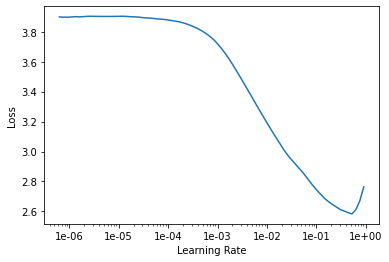

In [47]:
learn.lr_find()
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(20, 3e-03)

epoch,train_loss,valid_loss,accuracy,time
0,3.534980,3.259452,0.277604,00:00
1,2.820182,2.142501,0.464881,00:00
2,2.268466,2.038642,0.398810,00:00
3,1.939981,1.928808,0.392039,00:00
4,1.719438,1.821913,0.445238,00:00
5,1.535639,1.722762,0.497842,00:00
6,1.349714,1.757980,0.491146,00:00
7,1.166018,1.338645,0.574479,00:00
8,1.001379,1.238427,0.613393,00:00
9,0.835347,1.191368,0.623437,00:00


In [50]:
class MultiRNN(nn.Module):
  def __init__(self, nv = nv, np = np):
    super().__init__()
    self.i_h = nn.Embedding(nv, np)
    self.rnn = nn.RNN(np, np*2, num_layers = 2, batch_first = True)
    self.h_o = nn.Linear(np*2, nv)
    self.bn = BatchNorm1dFlat(np*2)
    self.h = torch.zeros(2, bs, np*2).cuda()

  def forward(self, x):
    h = self.h
    res, h = self.rnn(self.i_h(x), h)
    self.h = h.detach()
    return self.h_o(self.bn(res))

In [52]:
#test
rnn = MultiRNN().cuda()
res = rnn(x)
res.shape

torch.Size([32, 70, 40])

In [55]:
data = src.databunch(bs= bs)
learn = Learner(data, rnn, metrics = accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


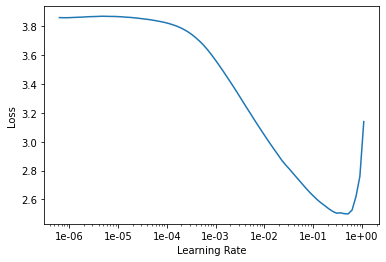

In [54]:
learn.lr_find()
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(20, 3e-03)

epoch,train_loss,valid_loss,accuracy,time
0,3.186336,2.769896,0.423363,00:00
1,2.528634,2.180074,0.468304,00:00
2,2.084182,1.975780,0.472768,00:00
3,1.781408,1.585398,0.528199,00:00
4,1.457933,1.361050,0.618378,00:00
5,1.105414,0.867623,0.725446,00:00
6,0.800234,0.625821,0.813616,00:00
7,0.564964,0.548071,0.845536,00:00
8,0.398250,0.496287,0.862723,00:00
9,0.281717,0.489124,0.868527,00:00
